<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/00_knn_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to apply a simple K-nearest neighbors on Cora dataset to understand the labels of the graph.

*NB: it is actually a slightly modified version of the KNN where we consider a k-hop neighborhood and not k neighbors*

The expectations are:
- the influence of node locality is way more significant than node features, in other words, we can label nodes just by looking at its neighbors
- we can compute the graph problem radius by plotting the accuracy w.r.t the size of the neighborhood considered

## Setting up the environment

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

## Building the model

In [3]:
from collections import Counter
from torch_geometric.utils import to_dense_adj

In [4]:
A = to_dense_adj(G.edge_index)

In [22]:
A = A.squeeze(0)

In [35]:
d = Counter([1, 2, 2, 2, 3, 1])

max(d, key=lambda x: d[x])

2

In [43]:
test_acc = 0
num_test_nodes = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        count = Counter(neb_labels)
        pred = max(count, key=lambda x: d[x])
        if pred == G.y[i]: test_acc += 1

In [41]:
test_acc / num_test_nodes

0.789

That is what I thought 🤯
A KNN with a 1-hop neighborhood performs better than most graph neural networks!!!

But we cheated a little bit. We looked at neighbors regardless of whether they are part of our training set. Let's see what happens if we just consider nodes from our training set:

In [46]:
test_acc = 0
num_test_nodes = 0
num_no_neighbors = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0 and G.train_mask[j]:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        if len(neb_labels) != 0:
            count = Counter(neb_labels)
            pred = max(count, key=lambda x: d[x])
            if pred == G.y[i]: test_acc += 1
        else:
            num_no_neighbors += 1

In [57]:
print(f"Test accuracy: {test_acc / num_test_nodes}")
print(f"{num_no_neighbors}/{num_test_nodes} () testing nodes had no training nodes in their direct neighborhood")

Test accuracy: 0.169
789/1000 testing nodes had no training nodes in their direct neighborhood


Ok now this an entirely different score. Because most of our testing nodes are actually neighbors with other testing nodes but not training nodes.

Let's try to increase the neighborhood by one.

In [53]:
def get_k_hop_neighborhood(k:int, i: int, adj: torch.tensor) -> list:
    """Returns the list of nodes in the k-hop neighborhood (recursively)
    
    Args:
        - k (int): size of the neighborhood
        - i (int): index of the target node
        - adj (torch.tensor): dense adjacency matrix
    """
    if k == 0: return []

    neighbors = []
    for j in range(adj.size(0)):
        if adj[i, j] != 0:
            neighbors.append(j)
            neighbors += get_k_hop_neighborhood(k-1, j, adj)
    
    return list(dict.fromkeys(neighbors))

In [59]:
K = 2
test_acc = 0
num_test_nodes = 0
num_no_neighbors = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        neb_labels = [G.y[j] for j in get_k_hop_neighborhood(K, i, A) if G.train_mask[j]]
        
        # find the most occurence in the neighborhood
        if len(neb_labels) != 0:
            count = Counter(neb_labels)
            pred = max(count, key=lambda x: d[x])
            if pred == G.y[i]: test_acc += 1
        else:
            num_no_neighbors += 1

In [60]:
print(f"Test accuracy: {test_acc / num_test_nodes}")
print(f"{num_no_neighbors}/{num_test_nodes} () testing nodes had no training nodes in their direct neighborhood")

Test accuracy: 0.448
382/1000 () testing nodes had no training nodes in their direct neighborhood


Ok this already much better, this is in comparison with a 2-layer GCN which performs the best.

Now let's put all of this into a function and run it over several neighborhood sizes to see how our performance evolves

In [61]:
def run(k: int):
    test_acc = 0
    num_test_nodes = 0
    num_no_neighbors = 0

    for i in range(G.num_nodes):
        if G.test_mask[i]:
            num_test_nodes += 1
            neb_labels = []
            # count all the labels from its neighbors
            neb_labels = [G.y[j] for j in get_k_hop_neighborhood(k, i, A) if G.train_mask[j]]
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: d[x])
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return test_acc, num_no_neighbors

In [ ]:
all_test_acc, all_num_no_neb = [], []
for k in range(1, 7):
    test_acc, num_no_neb = run(k)
    all_test_acc.append(test_acc)
    all_num_no_neb.append(num_no_neb)

In [65]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[Text(0.5, 1.0, 'KNN on Cora')]

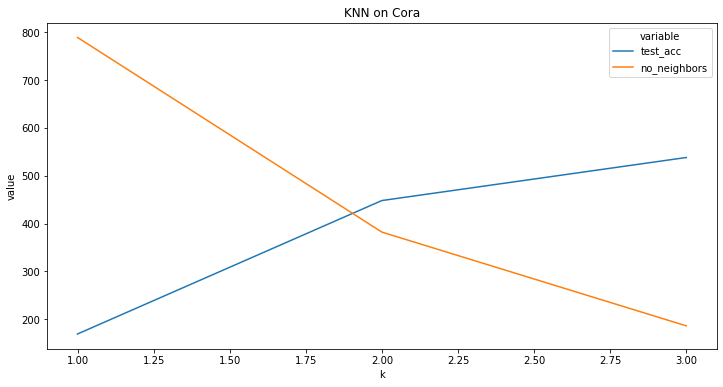

In [72]:
plt.figure(figsize=(12, 6))


data = pd.DataFrame({
    'k': range(1, 4),
    'test_acc': all_test_acc,
    'no_neighbors': all_num_no_neb
})

sns.lineplot(x='k', y='value', hue='variable', data=pd.melt(data, ['k'])).set(title="KNN on Cora")

Now let's try something different. We will run the KNN several time so that after labelling the nodes that we can label, we will have new neighbors to consider.
So we now have two hyperparameters:
- k: the size of the neighborhood
- n: the number of time we want to run the KNN

In [101]:
def run_and_label(k: int, labels:list):
    test_acc, num_test_nodes, num_no_neighbors = 0, 0, 0
    new_labels = labels.copy()

    for i in range(G.num_nodes):
        if G.test_mask[i]:
            num_test_nodes += 1
            neb_labels = []
            # count all the labels from its neighbors
            neb_labels = [labels[j] for j in get_k_hop_neighborhood(k, i, A) if labels[j] != -1]
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: d[x])
                new_labels[i] = pred
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return new_labels, test_acc/num_test_nodes, num_no_neighbors

In [ ]:
results = pd.DataFrame(columns=['k', 'n', 'test_acc', 'no_neb'])
id = 0

for k in range(1, 4):
    labels = [G.y[i].item() if G.train_mask[i] else -1 for i in range(G.num_nodes)]
    for n in range(1, 4):
        labels, test_acc, no_neb = run_and_label(k, labels)
        results.loc[id] = {'k':k, 'n':n, 'test_acc': test_acc, 'no_neb': no_neb}
        print(f"k: [{k}/3] | n: [{n}/3] | acc: {test_acc} | no_neighbors: {no_neb}")

        id += 1

k: [1/3] | n: [1/3] | acc: 0.169 | no_neighbors: 789
